Initial messing-around notebook for fuel & food.

Aims:

* get the data in and formatted (from Barchart.com)
* plot prices against prices
* plot change in price against change in price
* bring in a few techniques and then packages that aid with recognizing regime change from a time-series point of view
* look at techniques and packages that aid with recognizing structural change from a network point of view
* do some basic cointegration calculations

What can be included in a short session? What must be left to the side?

## Setup first

In [6]:
# Load in libraries needed to start
import numpy as np
import seaborn as sns
import pandas as pd
import sys
import matplotlib.pyplot as plt
import os


In [7]:
os.getcwd()

'/Users/kaisataipale/Documents/fuel-and-food/2_code'

## Data

This data is from Barchart.com. No claim of accuracy is made, don't trade on this, etc

In [147]:
rbob = pd.read_csv('../1_data/RBY00_Barchart_Interactive_Chart_Monthly_Nearby_05_27_2024.csv', header = 1)
corn = pd.read_csv('../1_data/ZCY00_Barchart_Interactive_Chart_Monthly_Nearby_05_27_2024.csv', header = 1)
beanoil = pd.read_csv('../1_data/ZLY00_Barchart_Interactive_Chart_Monthly_Nearby_05_27_2024.csv', header = 1)
soy = pd.read_csv('../1_data/ZSY00_Barchart_Interactive_Chart_Monthly_Nearby_05_27_2024.csv', header = 1)
crude = pd.read_csv('../1_data/CLY00_Barchart_Interactive_Chart_Monthly_Nearby_06_02_2024.csv', header = 1)
ulsd = pd.read_csv('../1_data/HOY00_Barchart_Interactive_Chart_Monthly_Nearby_06_02_2024.csv', header = 1)

In [128]:
rbob.head()

,Date Time,Symbol,Open,High,Low,Close,Change,Volume,Open Interest
0,1978-09-01,RBY00,0.4850,0.485,0.485,0.4850,0.0000,NaN,NaN
1,1978-10-01,RBY00,0.4720,0.490,0.472,0.4900,0.0050,NaN,NaN
2,1978-11-01,RBY00,0.4900,0.570,0.490,0.5500,0.0600,NaN,NaN
3,1978-12-01,RBY00,0.5500,0.550,0.530,0.5375,-0.0125,NaN,NaN
4,1979-01-01,RBY00,0.5325,0.570,0.525,0.5700,0.0325,NaN,NaN


In [129]:
corn.tail()

,Date Time,Symbol,Open,High,Low,Close,Change,Volume,Open Interest
636,2024-02-01,ZCY00,438.25,438.25,377.25,406.000,-33.250,457667.0,1584157.0
637,2024-03-01,ZCY00,403.25,427.00,403.25,427.000,21.000,312072.0,1550565.0
638,2024-04-01,ZCY00,425.50,447.00,416.50,444.625,17.625,434622.0,1536514.0
639,2024-05-01,ZCY00,449.50,481.50,449.50,472.750,28.125,399802.0,1495984.0
640,Downloaded from Barchart.com as of 05-27-2024 ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Note that every file from Barchart has this line saying that it's downloaded from Barchart, which is 100% fair. To continue to transform the data in Python, we need to make a copy of the dataframe without this in the date column.

In [148]:
## Need to deal with datetimes, last line
commodities_dict = {'corn': corn,
                   'rbob': rbob, 
                   'soy': soy,
                   'crude': crude,
                   'beanoil': beanoil,
                   'soy': soy, 
                   'ulsd': ulsd}

In [149]:
for commodity in commodities_dict.keys():
    df = commodities_dict[commodity]
    df.drop(df.tail(1).index,inplace=True)

In [150]:
corn.tail()

,Date Time,Symbol,Open,High,Low,Close,Change,Volume,Open Interest
635,2024-01-01,ZCY00,466.25,470.375,431.25,439.250,-27.000,316074.0,1497444.0
636,2024-02-01,ZCY00,438.25,438.250,377.25,406.000,-33.250,457667.0,1584157.0
637,2024-03-01,ZCY00,403.25,427.000,403.25,427.000,21.000,312072.0,1550565.0
638,2024-04-01,ZCY00,425.50,447.000,416.50,444.625,17.625,434622.0,1536514.0
639,2024-05-01,ZCY00,449.50,481.500,449.50,472.750,28.125,399802.0,1495984.0


In [151]:
for commodity in commodities_dict.keys():
    df = commodities_dict[commodity]
    df['Date Time'] = pd.to_datetime(df['Date Time'])

## Basic plots

First use your eyeballs to look at the data

<Axes: xlabel='Date Time', ylabel='Close'>

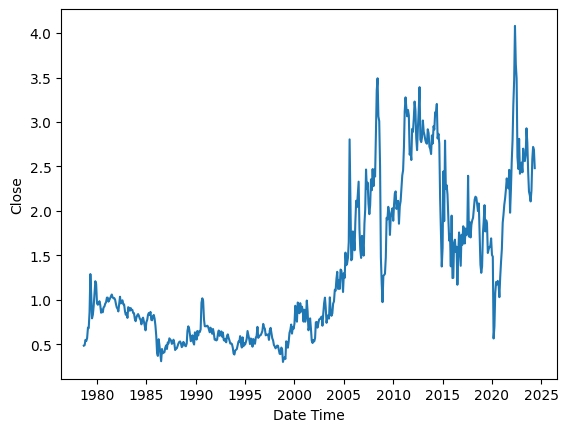

In [152]:
sns.lineplot(data = rbob, x = 'Date Time', y = 'Close')


<Axes: xlabel='Date Time', ylabel='Close'>

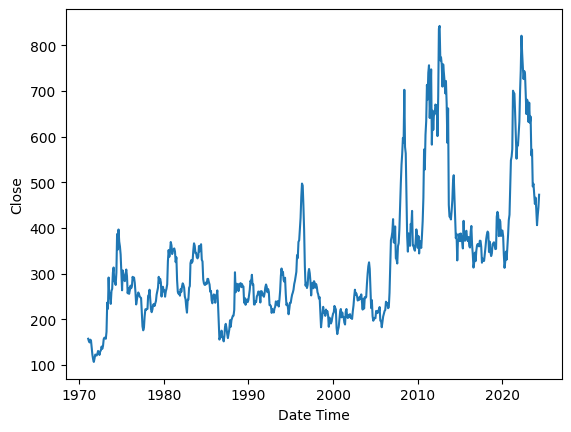

In [153]:
sns.lineplot(data = corn, x = 'Date Time', y = 'Close')

Let's scale corn and rbob to look at them on the same scale. I'm just going to scale by a nice number picked because of the illustrative effect.

In [139]:
corn_and_gas = corn.merge(rbob, on = 'Date Time', suffixes = ['_corn','_rbob'])

In [140]:
corn_and_gas['scaled_corn'] = corn_and_gas['Close_corn']/(200)
corn_and_gas['scaled_gas'] = corn_and_gas['Close_rbob']

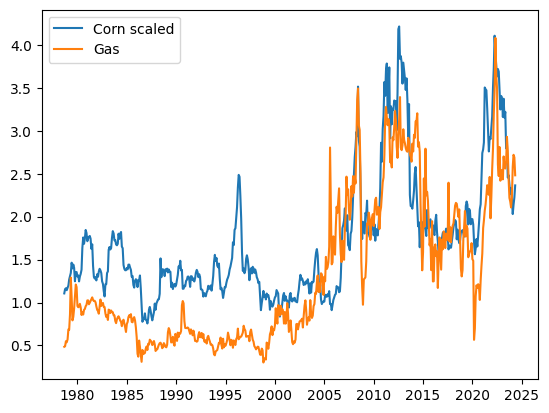

In [141]:
plt.plot(corn_and_gas['Date Time'], corn_and_gas['scaled_corn'], label = 'Corn scaled')
plt.plot(corn_and_gas['Date Time'], corn_and_gas['scaled_gas'], label = 'Gas')
plt.legend()

Well that's somewhat evocative, isn't it? But correlation isn't causation, and making graphs lie on top of each other doesn't prove anything either. 

We got "Change" for free from Barchart. What if we plot those? Convert to the same scale by doing change over close

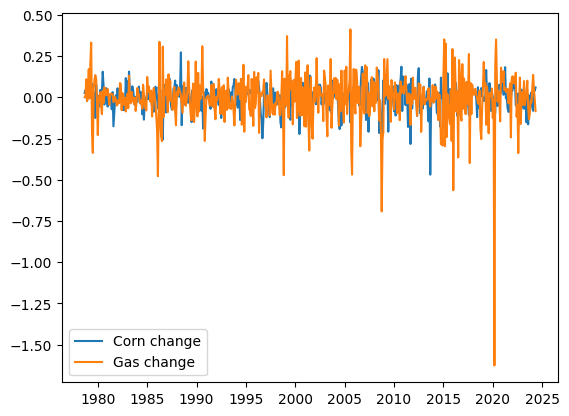

In [142]:
plt.plot(corn_and_gas['Date Time'], corn_and_gas['Change_corn']/corn_and_gas['Close_corn'], label = 'Corn change')
plt.plot(corn_and_gas['Date Time'], corn_and_gas['Change_rbob']/corn_and_gas['Close_rbob'], label = 'Gas change')
plt.legend()

That's too ugly to see anything. Fine. How about correlations? Let's do a rolling 12-month correlation.

Text(0.5, 1.0, 'Correlation on monthly price, rolling 24-month')

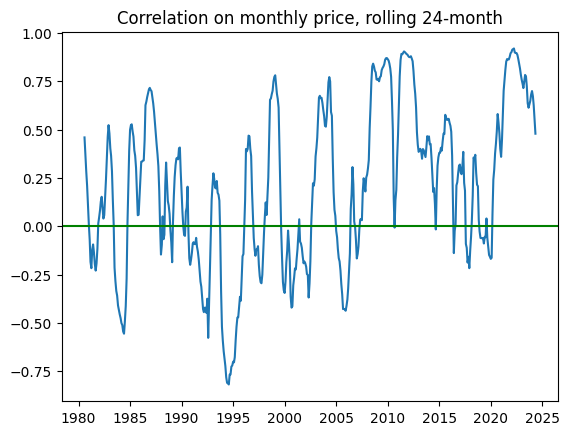

In [143]:
plt.plot(corn_and_gas['Date Time'], corn_and_gas['Close_corn'].rolling(24).corr(corn_and_gas['Close_rbob']))
plt.axhline(0, color = 'green')
plt.title('Correlation on monthly price, rolling 24-month')

Text(0.5, 1.0, 'Correlation on monthly price, rolling 36-month')

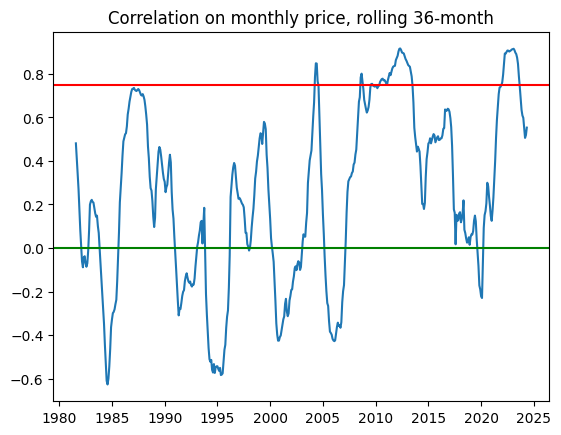

In [144]:
plt.plot(corn_and_gas['Date Time'], corn_and_gas['Close_corn'].rolling(36).corr(corn_and_gas['Close_rbob']))
plt.axhline(0, color = 'green')
plt.axhline(0.75, color = 'red')
plt.title('Correlation on monthly price, rolling 36-month')

Text(0.5, 1.0, 'Correlation in monthly % change in price, rolling 24-month')

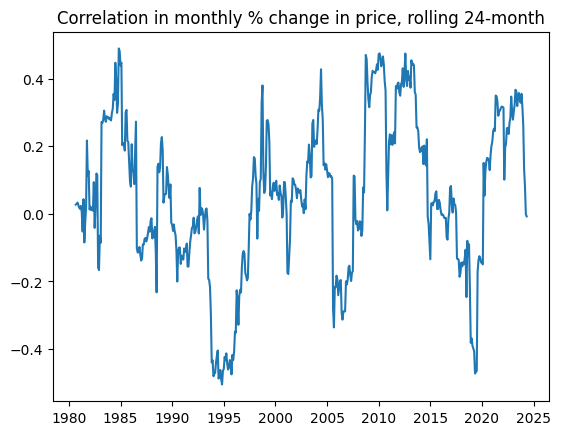

In [145]:
plt.plot(corn_and_gas['Date Time'], corn_and_gas['Close_corn'].pct_change().rolling(24).corr(corn_and_gas['Close_rbob'].pct_change()))
plt.title("Correlation in monthly % change in price, rolling 24-month")

Text(0.5, 1.0, 'Correlation in monthly % change in price, rolling 36-month')

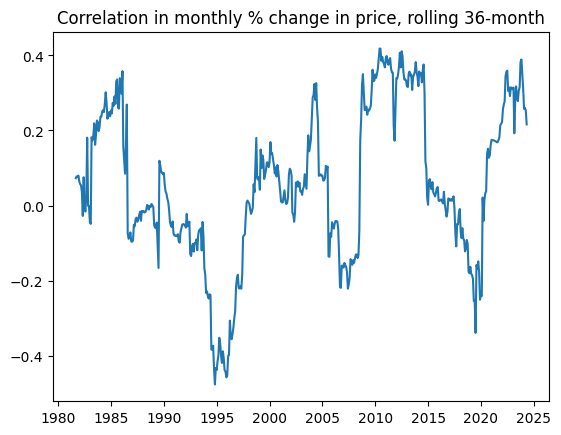

In [146]:
plt.plot(corn_and_gas['Date Time'], corn_and_gas['Close_corn'].pct_change().rolling(36).corr(corn_and_gas['Close_rbob'].pct_change()))
plt.title("Correlation in monthly % change in price, rolling 36-month")

In [156]:
beanoil_and_ulsd = beanoil.merge(ulsd, on = 'Date Time', suffixes = ['_bo','_ulsd'])

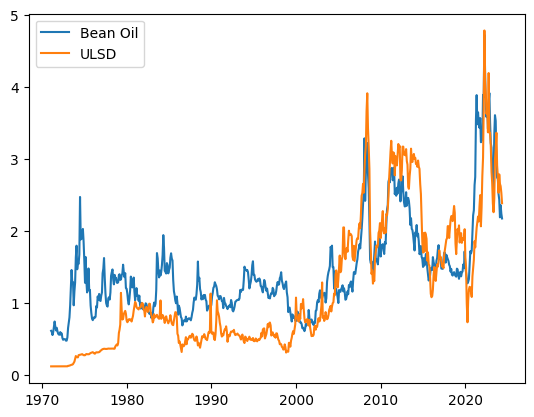

In [159]:
# Let's repeat the process for bean oil and ULSD
plt.plot(beanoil_and_ulsd['Date Time'], beanoil_and_ulsd['Close_bo']/20, label = 'Bean Oil')
plt.plot(beanoil_and_ulsd['Date Time'], beanoil_and_ulsd['Close_ulsd'], label = 'ULSD')
plt.legend()

Again, sort of suggestive, but.... still some significant differences. Note that all I did was scale to make the charts line up, there is no science here yet.

Text(0.5, 1.0, 'Correlation on monthly price, rolling 36-month')

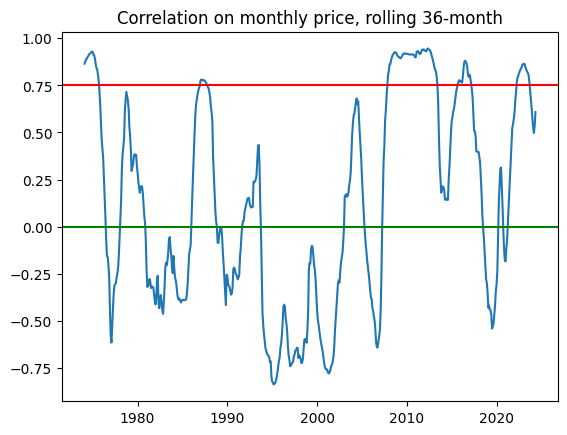

In [160]:
plt.plot(beanoil_and_ulsd['Date Time'], beanoil_and_ulsd['Close_bo'].rolling(36).corr(beanoil_and_ulsd['Close_ulsd']))
plt.axhline(0, color = 'green')
plt.axhline(0.75, color = 'red')
plt.title('Correlation on monthly price, rolling 36-month')

Text(0.5, 1.0, 'Correlation in monthly % change in price, rolling 24-month')

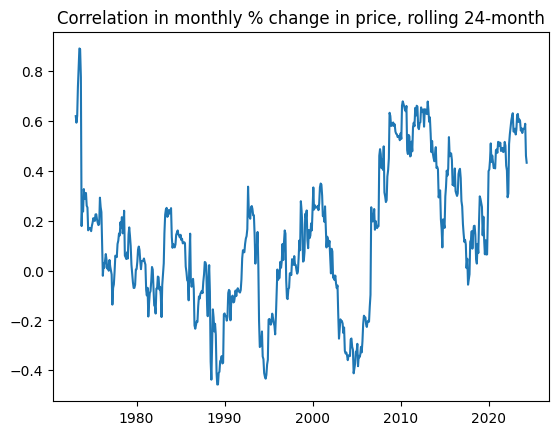

In [161]:
plt.plot(beanoil_and_ulsd['Date Time'], beanoil_and_ulsd['Close_bo'].pct_change().rolling(24).corr(beanoil_and_ulsd['Close_ulsd'].pct_change()))
plt.title("Correlation in monthly % change in price, rolling 24-month")

Worth looking at commodity supercycles here?
https://www.visualcapitalist.com/what-is-a-commodity-super-cycle/

## Basic time series analysis

Prophet is quick & dirty. Sometimes it's the right tool for the job, sometimes not. In Python it's one of the faster ways to get started. In R there are more powerful quick-start approaches IMO.

## Regime change/changepoint detection first pass

Newer to me packages: ruptures, detecta, the bayesian one

In [70]:
%pip install ruptures
%pip install detecta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.1/308.1 kB 1.3 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for ruptures: filename=ruptures-1.1.9-cp311-cp311-macosx_12_0_arm64.whl size=474478 sha256=f83d726e074a64fa8d8c87efb84ffa23b2955e2435d1e9ae38c8420ef9e0c7f7
  Stored in directory: /Users/kaisataipale/Library/Caches/pip/wheels/91/4b/b2/08e23635050124c9dfc36d6a86ca63f025a8aa86c31a7e011d
Successfully built ruptures

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [71]:
import ruptures as rpt
import detecta as dta

In [74]:
corn

,Date Time,Symbol,Open,High,Low,Close,Change,Volume,Open Interest
0,1971-02-01,ZCY00,156.50,160.000,155.50,157.000,0.000,13646.0,72173.0
1,1971-03-01,ZCY00,156.50,158.000,152.00,152.000,-5.000,15845.0,61893.0
2,1971-04-01,ZCY00,152.75,155.000,146.25,149.000,-3.000,15265.0,53894.0
3,1971-05-01,ZCY00,149.75,155.000,148.50,155.000,6.000,17052.0,45821.0
4,1971-06-01,ZCY00,154.00,163.750,151.75,153.500,-1.500,28895.0,51193.0
...,...,...,...,...,...,...,...,...,...
635,2024-01-01,ZCY00,466.25,470.375,431.25,439.250,-27.000,316074.0,1497444.0
636,2024-02-01,ZCY00,438.25,438.250,377.25,406.000,-33.250,457667.0,1584157.0
637,2024-03-01,ZCY00,403.25,427.000,403.25,427.000,21.000,312072.0,1550565.0
638,2024-04-01,ZCY00,425.50,447.000,416.50,444.625,17.625,434622.0,1536514.0


In [77]:
algo = rpt.Pelt(model = "rbf").fit(np.array(corn['Close']))


In [78]:
result = algo.predict(pen=10)

In [90]:
corn.head()

,Date Time,Symbol,Open,High,Low,Close,Change,Volume,Open Interest
0,1971-02-01,ZCY00,156.50,160.00,155.50,157.0,0.0,13646.0,72173.0
1,1971-03-01,ZCY00,156.50,158.00,152.00,152.0,-5.0,15845.0,61893.0
2,1971-04-01,ZCY00,152.75,155.00,146.25,149.0,-3.0,15265.0,53894.0
3,1971-05-01,ZCY00,149.75,155.00,148.50,155.0,6.0,17052.0,45821.0
4,1971-06-01,ZCY00,154.00,163.75,151.75,153.5,-1.5,28895.0,51193.0


In [96]:
corn.tail()

,Date Time,Symbol,Open,High,Low,Close,Change,Volume,Open Interest
635,2024-01-01,ZCY00,466.25,470.375,431.25,439.250,-27.000,316074.0,1497444.0
636,2024-02-01,ZCY00,438.25,438.250,377.25,406.000,-33.250,457667.0,1584157.0
637,2024-03-01,ZCY00,403.25,427.000,403.25,427.000,21.000,312072.0,1550565.0
638,2024-04-01,ZCY00,425.50,447.000,416.50,444.625,17.625,434622.0,1536514.0
639,2024-05-01,ZCY00,449.50,481.500,449.50,472.750,28.125,399802.0,1495984.0


In [97]:
# Let's print the changepoint datetimes detected by ruptures

for ix in result:
    print(corn.loc[ix-1, 'Date Time'])
#2005 -- first Renewable Fuel Standard passed
# We'd expect this to have interesting dates in corn markets as well
#https://www.bls.gov/opub/ted/2012/ted_20121128.htm

1973-02-01 00:00:00
1998-07-01 00:00:00
2006-11-01 00:00:00
2010-08-01 00:00:00
2013-07-01 00:00:00
2021-01-01 00:00:00
2024-05-01 00:00:00


(<Figure size 1000x200 with 1 Axes>, [<Axes: >])

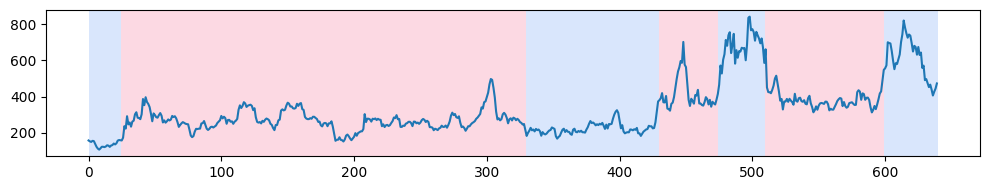

In [92]:
rpt.display(corn['Close'], result)
#plt.plot(corn['Date Time'],corn['Close'])

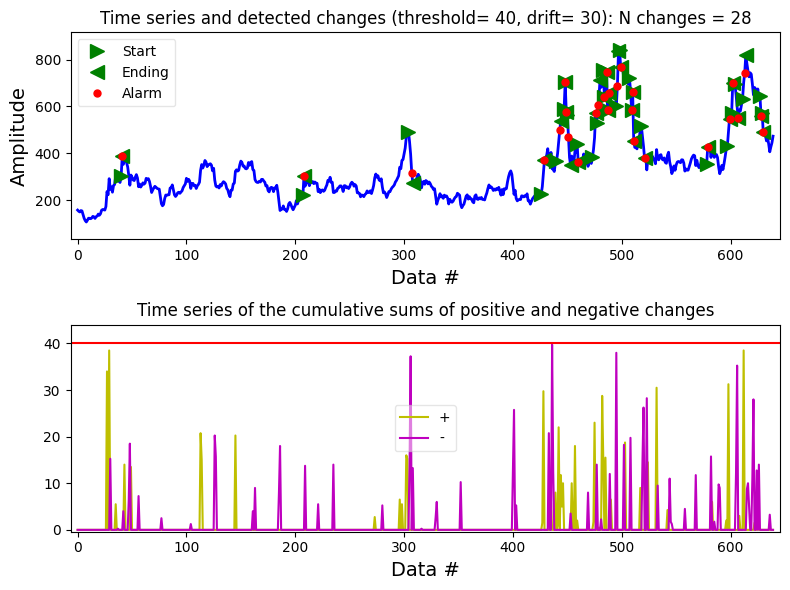

(array([ 41, 208, 307, 429, 443, 448, 449, 451, 460, 476, 478, 484, 486,
        487, 488, 496, 499, 509, 510, 511, 521, 579, 599, 602, 607, 613,
        628, 630]),
 array([ 40, 207, 304, 426, 440, 447, 448, 450, 459, 473, 477, 483, 484,
        486, 487, 495, 498, 507, 509, 510, 518, 578, 597, 601, 604, 611,
        627, 629]),
 array([ 41, 208, 308, 429, 444, 448, 449, 453, 460, 476, 480, 484, 486,
        487, 488, 497, 499, 509, 510, 511, 521, 579, 599, 602, 607, 614,
        628, 630]),
 array([  84.25,   82.5 , -219.25,  147.  ,  172.5 ,  115.5 , -125.25,
        -215.25,  -75.5 ,  189.25,  185.5 , -115.5 ,  106.5 , -165.  ,
          74.5 ,  235.25,  -75.5 , -135.5 ,   75.5 , -211.5 , -138.  ,
          70.25,  119.25,  128.  , -142.5 ,  188.25,  -85.  ,  -80.5 ]))

In [111]:
dta.detect_cusum(corn['Close'], 40, 30, True, True)

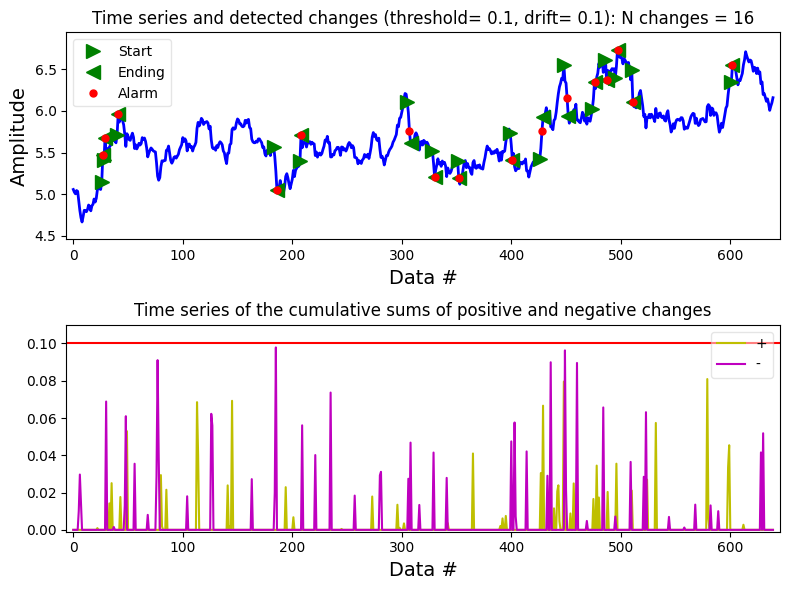

(array([ 27,  29,  41, 186, 208, 307, 330, 352, 401, 428, 451, 476, 487,
        497, 511, 602]),
 array([ 26,  28,  40, 183, 207, 305, 328, 351, 399, 426, 448, 474, 486,
        495, 510, 601]),
 array([ 27,  29,  41, 186, 208, 308, 330, 352, 401, 429, 452, 476, 487,
        497, 511, 602]),
 array([ 0.31594366,  0.26813194,  0.24587738, -0.52711731,  0.31814412,
        -0.4962779 , -0.30905693, -0.20104784, -0.3238108 ,  0.50104342,
        -0.61089036,  0.32206602, -0.24940512,  0.3302157 , -0.38490748,
         0.20170187]))

In [118]:
dta.detect_cusum(np.log(corn['Close']), .1, .1, True, True)

In [82]:
corr_corn_rbob = corn_and_gas['Close_corn'].pct_change().rolling(36).corr(corn_and_gas['Close_rbob'].pct_change()).dropna()
algo2 = rpt.Pelt(model = "rbf").fit(np.array(corr_corn_rbob))

In [83]:
result2 = algo2.predict(pen=10)

(<Figure size 1000x200 with 1 Axes>, [<Axes: >])

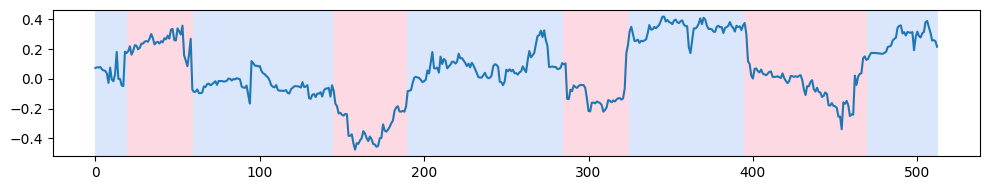

In [98]:
rpt.display(corr_corn_rbob, result2)
# It would be nice to display this with the dates on the axes, no?


In [99]:
result2
# 513 is the lenght of the series, so these #s are NOT the pandas index but instead index of np.array

[20, 60, 145, 190, 285, 325, 395, 470, 513]

To get back to the date, we need to bring the correlation back to dates from the original time series



In [87]:
corr_corn_rbob

36     0.072953
37     0.077768
38     0.075578
39     0.079918
40     0.063952
         ...   
544    0.310965
545    0.257640
546    0.260488
547    0.252961
548    0.216262
Length: 513, dtype: float64

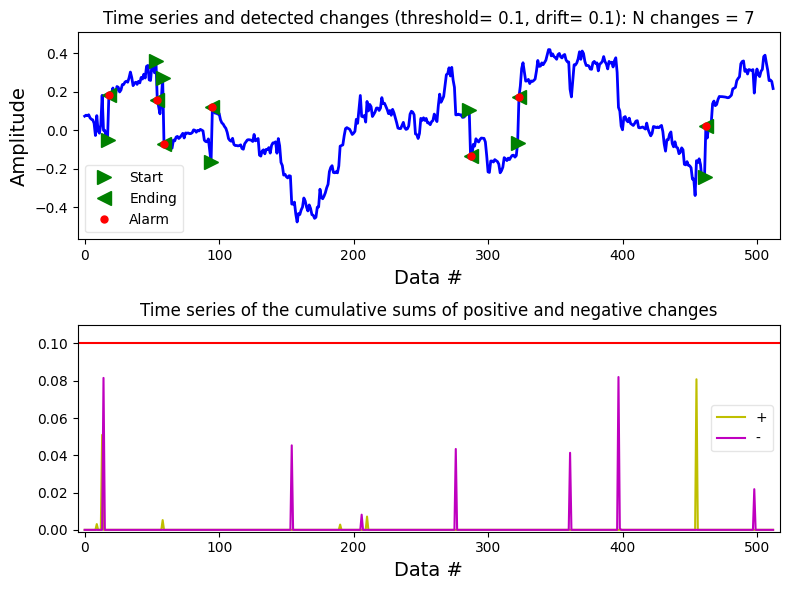

(array([ 18,  54,  59,  95, 287, 323, 462]),
 array([ 17,  53,  58,  94, 286, 322, 461]),
 array([ 18,  54,  59,  95, 287, 323, 462]),
 array([ 0.23079439, -0.20015556, -0.34247388,  0.28541032, -0.23918484,
         0.23919706,  0.26233885]))

In [105]:
dta.detect_cusum(corr_corn_rbob, .1, .1, True, True)

In [ ]:
## Correlation is problematic, so may need to use patched version


In [121]:
## Examples with Detecta

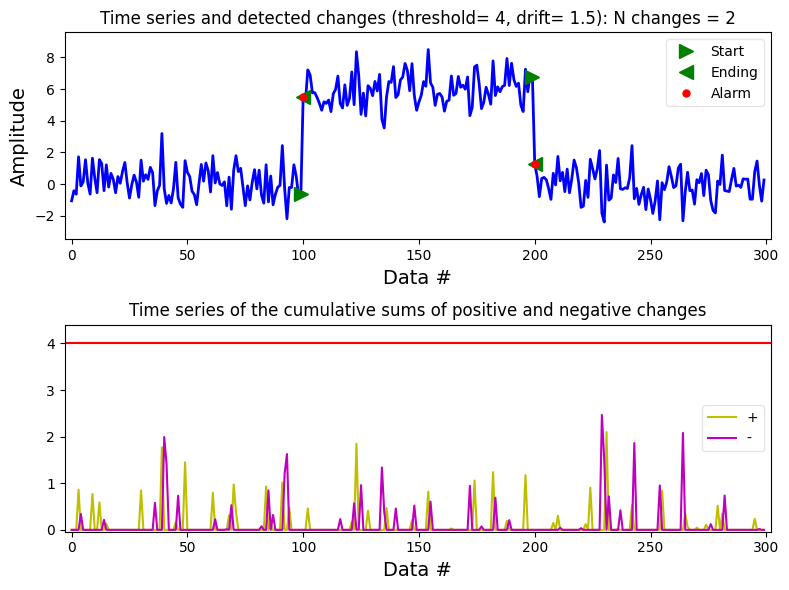

(array([100, 200]),
 array([ 99, 199]),
 array([100, 200]),
 array([ 6.19257445, -5.52050344]))

In [101]:
x = np.random.randn(300)
x[100:200] += 6
dta.detect_cusum(x, 4, 1.5, True, True)



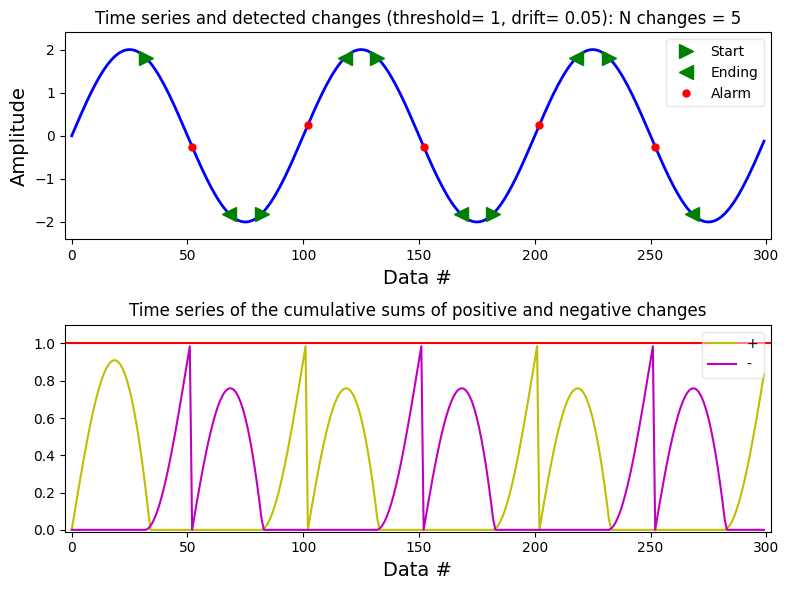

In [120]:
x = 2*np.sin(2*np.pi*np.arange(0, 3, .01))
ta, tai, taf, amp = dta.detect_cusum(x, 1, .05, True, True)



## Heatmap approach

Can eyeball things with one commodity.


## Network approach

Rather than looking one by one at series (price, returns, or correlation) we could also look at the network of relationships of all the series, which can be illuminating as well. 

A very basic way of doing this is using the correlation matrix to make a similarity or dissimilarity matrix, then making a graph out of that using a threshold. For only a few commodities, this isn't the most exciting, though it works.

In [164]:
# Make a dataframe of all the commodities, crue, rbob, corn, soy, beanoil
crbu = corn_and_gas.merge(beanoil_and_ulsd, on = 'Date Time')
crbu.head()

,Date Time,Symbol_corn,Open_corn,High_corn,Low_corn,Close_corn,Change_corn,Volume_corn,Open Interest_corn,Symbol_rbob,...,Volume_bo,Open Interest_bo,Symbol_ulsd,Open_ulsd,High_ulsd,Low_ulsd,Close_ulsd,Change_ulsd,Volume_ulsd,Open Interest_ulsd
0,1978-09-01,ZCY00,214.00,221.25,212.00,221.25,6.00,39771.0,114110.0,RBY00,...,20426.0,51302.0,HOY00,0.3975,0.3975,0.3975,0.3975,0.0315,NaN,NaN
1,1978-10-01,ZCY00,224.50,234.25,219.50,231.25,10.00,49621.0,140100.0,RBY00,...,25947.0,53980.0,HOY00,0.3975,0.4270,0.3550,0.4100,0.0125,NaN,NaN
2,1978-11-01,ZCY00,229.75,236.00,228.25,233.25,2.00,54467.0,147236.0,RBY00,...,25726.0,57406.0,HOY00,0.4100,0.4238,0.4100,0.4238,0.0138,NaN,5.0
3,1978-12-01,ZCY00,234.00,234.00,227.00,228.75,-4.50,34309.0,130630.0,RBY00,...,20170.0,53960.0,HOY00,0.4236,0.4275,0.4075,0.4100,-0.0138,3.0,31.0
4,1979-01-01,ZCY00,227.75,235.00,225.50,234.50,5.75,31265.0,127928.0,RBY00,...,19544.0,50025.0,HOY00,0.4100,0.4450,0.3620,0.4450,0.0350,16.0,174.0


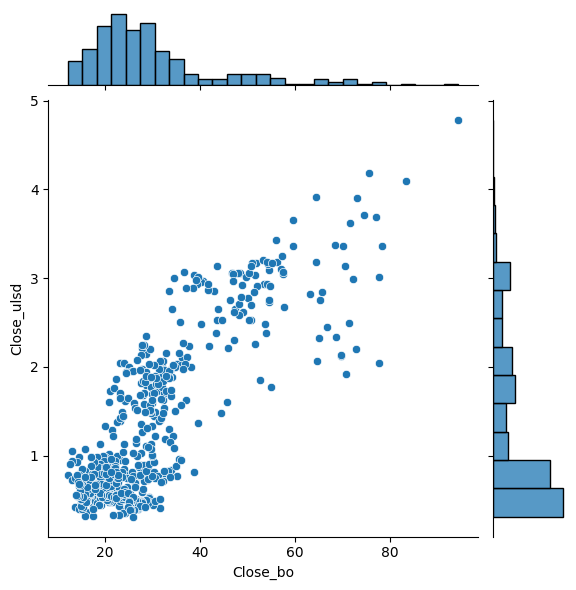

In [184]:
sns.jointplot(data = crbu, x = 'Close_bo', y = 'Close_ulsd')

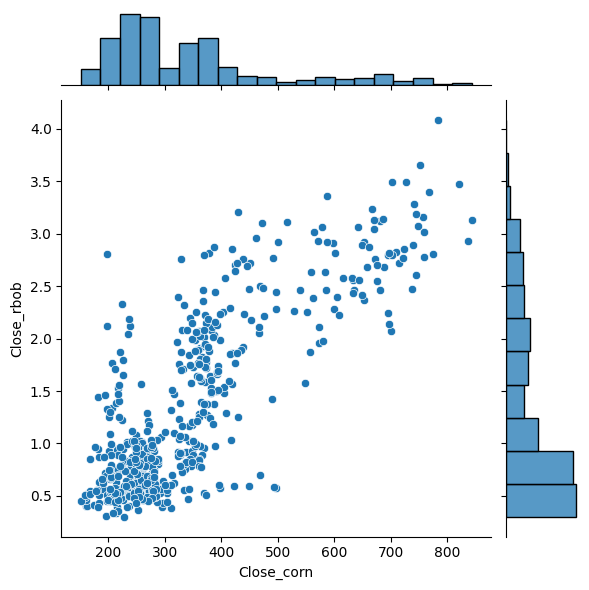

In [185]:
sns.jointplot(data = crbu, x = 'Close_corn', y = 'Close_rbob')

In [174]:
close_cols = [ 'Close_corn', 'Close_rbob', 'Close_ulsd', 'Close_bo']

In [166]:
crbu = crbu[['Date Time', 'Close_corn', 'Close_rbob', 'Close_ulsd', 'Close_bo']]

In [168]:
# Compute correlations over chunks of time -- a correlation matrix for each chunk
# np.log(df.price / df.price.shift(1))
crbu_logret = np.log(crbu[['Close_corn', 'Close_rbob', 'Close_ulsd', 'Close_bo']]/crbu[['Close_corn', 'Close_rbob', 'Close_ulsd', 'Close_bo']].shift(1))

In [170]:
crbu_logret['Date'] = crbu['Date Time']
crbu_logret.dropna(inplace = True)

In [171]:
crbu_logret.head()

,Close_corn,Close_rbob,Close_ulsd,Close_bo,Date
1,0.044206,0.010257,0.030962,-0.000742,1978-10-01
2,0.008611,0.115513,0.033104,-0.049440,1978-11-01
3,-0.019481,-0.022990,-0.033104,-0.003124,1978-12-01
4,0.024826,0.058708,0.081917,0.006626,1979-01-01
5,0.022141,0.187425,0.273538,0.075910,1979-02-01


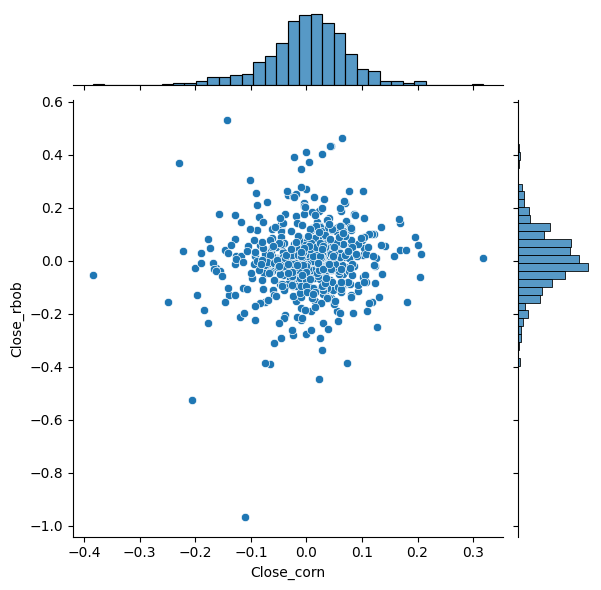

In [182]:
sns.jointplot(data = crbu_logret, x = 'Close_corn', y = 'Close_rbob')

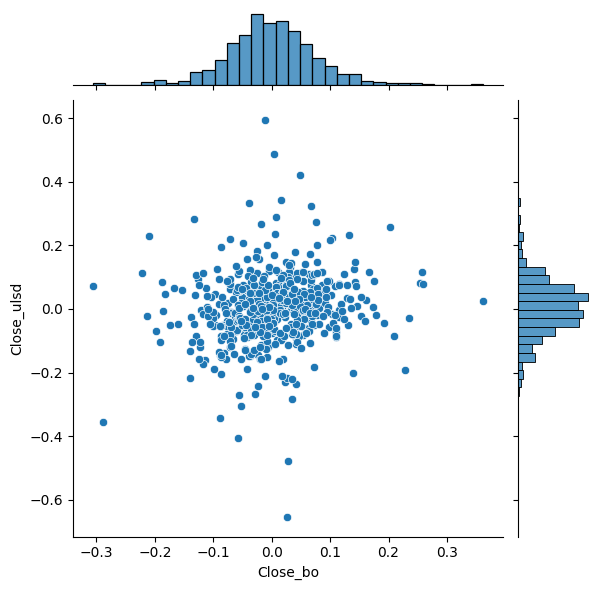

In [183]:
sns.jointplot(data = crbu_logret, x = 'Close_bo', y = 'Close_ulsd')

In [172]:
# Let's just make a set of yearly correlations. So make a list of all the years from 1979 to 2023, 
# and for each year, do the correlation.
# Honestly, maybe do this with 2-year chunks because 12 observations is kinda weak

list_of_years = pd.date_range(start='1979-01-01', periods=45, freq='YS')


In [175]:
yrly_corr_dict = {}
for year in list_of_years:
    temp_df = crbu_logret[(crbu_logret['Date']>= pd.to_datetime(year)) & (crbu_logret['Date']<= pd.to_datetime(year)+pd.DateOffset(years=1))]
    yrly_corr_dict[year] = temp_df[close_cols].corr()

In [178]:
yrly_corr_dict[pd.to_datetime('2023-01-01')]

,Close_corn,Close_rbob,Close_ulsd,Close_bo
Close_corn,1.000000,0.276565,-0.091151,-0.520066
Close_rbob,0.276565,1.000000,0.429328,0.414081
Close_ulsd,-0.091151,0.429328,1.000000,0.446401
Close_bo,-0.520066,0.414081,0.446401,1.000000


In [180]:
# The other way to do this is make a matrix that's six columns wide, with teh correlation for each year. This si probably good to do as well
yrly_corr_wide_df = pd.DataFrame(columns = ['year','rbob_corn', 'ulsd_corn', 'bo_corn', 'rbob_bo', 'ulsd_bo', 'rbob_ulsd'])


In [ ]:
for i, year in enumerate(list_of_years):
    yrly_corr_wide_df.loc[i,'year'] = year
    temp_df = crbu_logret[(crbu_logret['Date']>= pd.to_datetime(year)) & (crbu_logret['Date']<= pd.to_datetime(year)+pd.DateOffset(years=1))]
    yrly_corr_wide_df.loc[i, ]

In [ ]:
# From teh correlation matrix, create an appropriate matrix for teh graph. 
# I want high correlation to correspond to closer nodes in my graph, so I'll do 1-correlation for the edge weight
# This makes max correlation correspond to minimum distance, and so gives a distance between [0,2] for all edges


In [ ]:
# An alternative way to consider that might be easier with static node placement is to fix the nodes, but
# make teh correlation correspond to the weight (thickness) of the edge. Edge weights are hard with networkx
# But in that case, I'd do correlation alone for the weight of the edge but only put edges for positive correlation,
# (or if I'm interestd in both, do color)

In [ ]:
# After constructing the distance graph, can visualize the graphs using networkx


## Singular value decomp 

because I love it